<a href="https://colab.research.google.com/github/Misha-private/Demo-repo/blob/main/2D_Shallow_Water_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Main] Device=cuda, PhysicsLoss=True, ML_SUBSTEPS=3
[FD] Generate C-grid: H=30, W=30, dt=19.682903s, substeps=2, steps=300, nu=1500.0
  [FD] step 0/300
  [FD] step 100/300
  [FD] step 200/300
[FD] Shapes: h(300, 30, 30), u(300, 30, 31), v(300, 31, 30), dt=19.6829s
[Data] windows total=199, train=40, val=20 (stride=4)
[Speed] torch.compile enabled
[Train] Starting ...
  [Train] window 1/40 t0=0 ep=1


W0921 12:42:50.066000 3148 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(


    [k= 20] L_state=2.376e-01, L_phys=4.759e-05, pw=1.00
    [k= 40] L_state=1.344e+00, L_phys=3.006e-05, pw=1.00
    [k= 60] L_state=1.467e+00, L_phys=2.557e-05, pw=1.00
    [k= 80] L_state=1.467e+00, L_phys=2.492e-05, pw=1.00
    [k=100] L_state=1.467e+00, L_phys=2.090e-05, pw=1.00
    [k= 20] L_state=2.606e+00, L_phys=6.753e-05, pw=1.00
    [k= 40] L_state=4.681e+00, L_phys=4.897e-05, pw=1.00
    [k= 60] L_state=5.922e+00, L_phys=3.715e-05, pw=1.00
    [k= 80] L_state=6.814e+00, L_phys=3.558e-05, pw=1.00
    [k=100] L_state=7.538e+00, L_phys=3.548e-05, pw=1.00
    [k= 20] L_state=2.529e+00, L_phys=7.252e-05, pw=1.00
    [k= 40] L_state=3.376e+00, L_phys=5.277e-05, pw=1.00
    [k= 60] L_state=3.494e+00, L_phys=4.976e-05, pw=1.00
    [k= 80] L_state=3.736e+00, L_phys=5.121e-05, pw=1.00
    [k=100] L_state=4.190e+00, L_phys=5.569e-05, pw=1.00
    [k= 20] L_state=1.889e+00, L_phys=4.180e-05, pw=1.00
    [k= 40] L_state=2.359e+00, L_phys=4.460e-05, pw=1.00
    [k= 60] L_state=2.518e+00, 

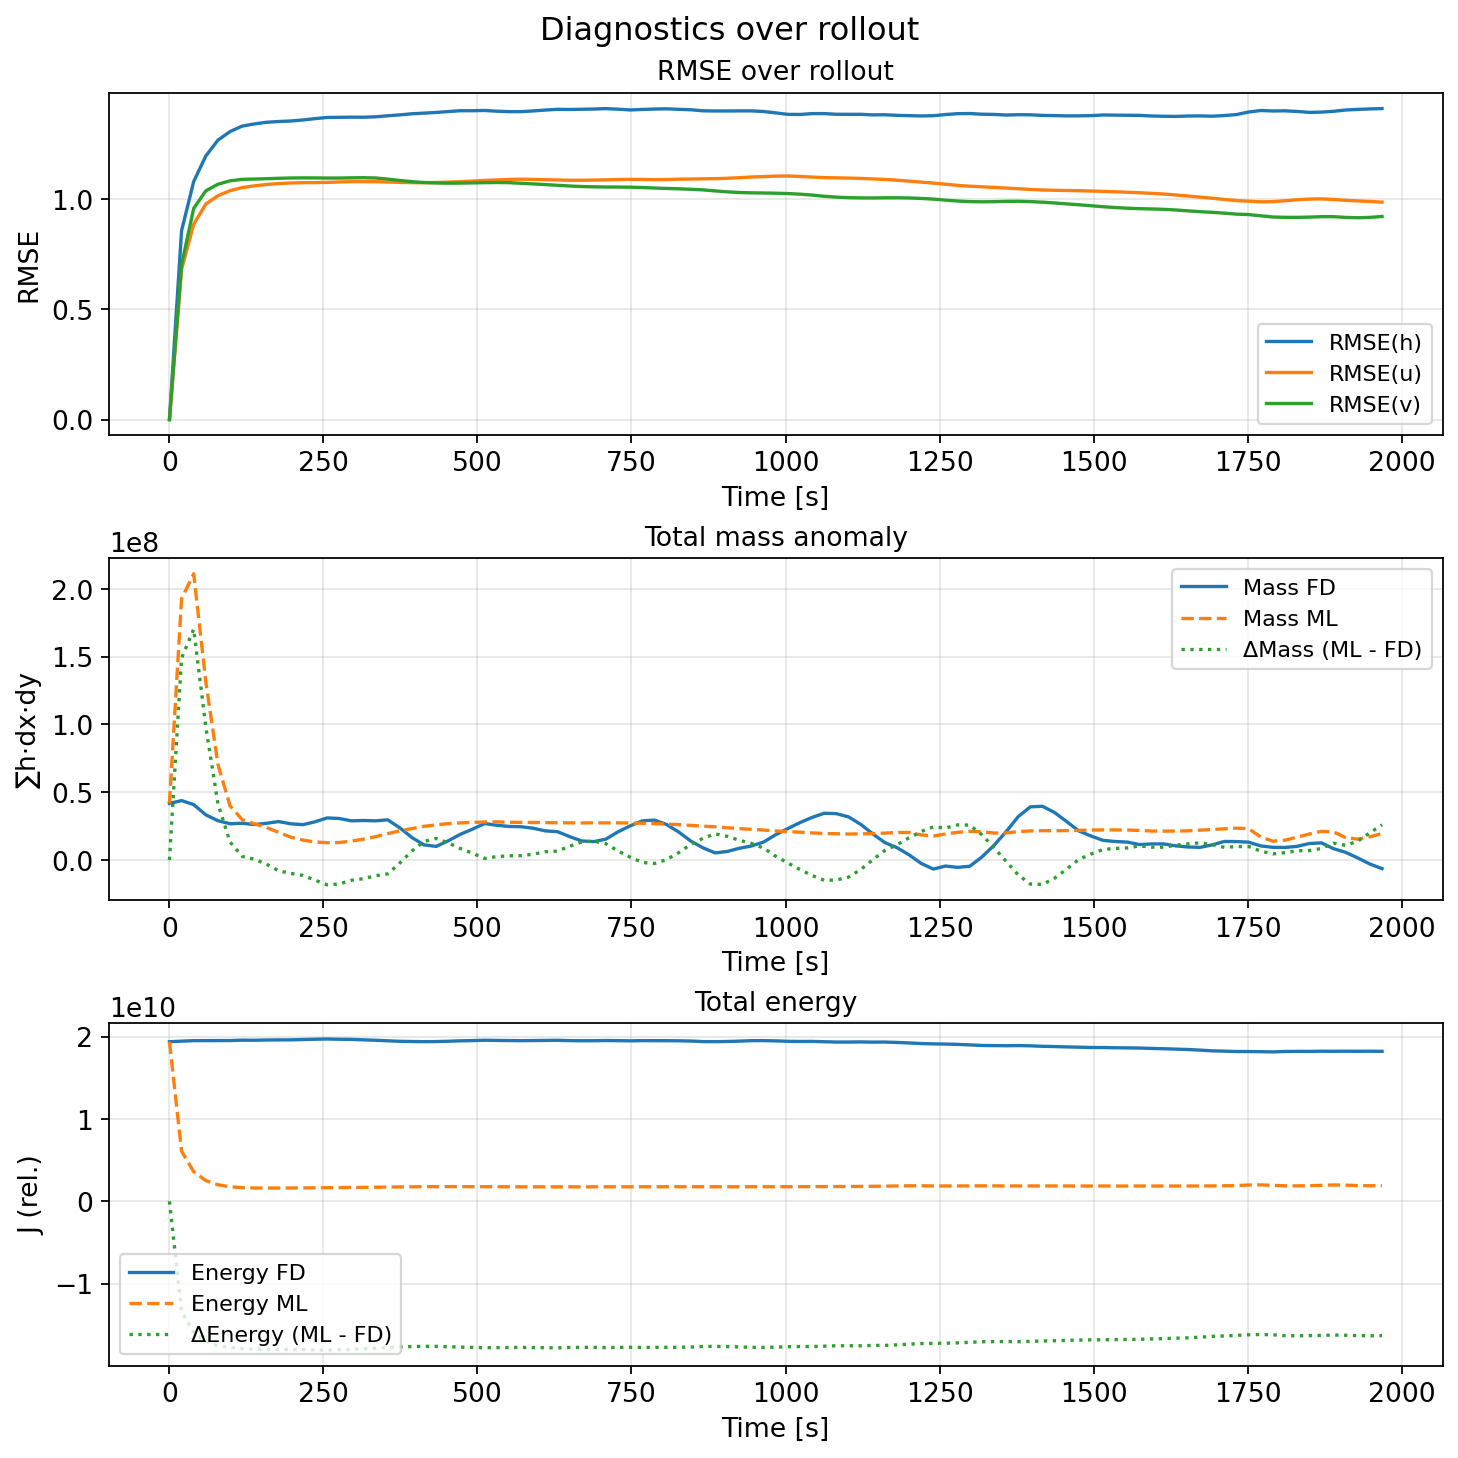

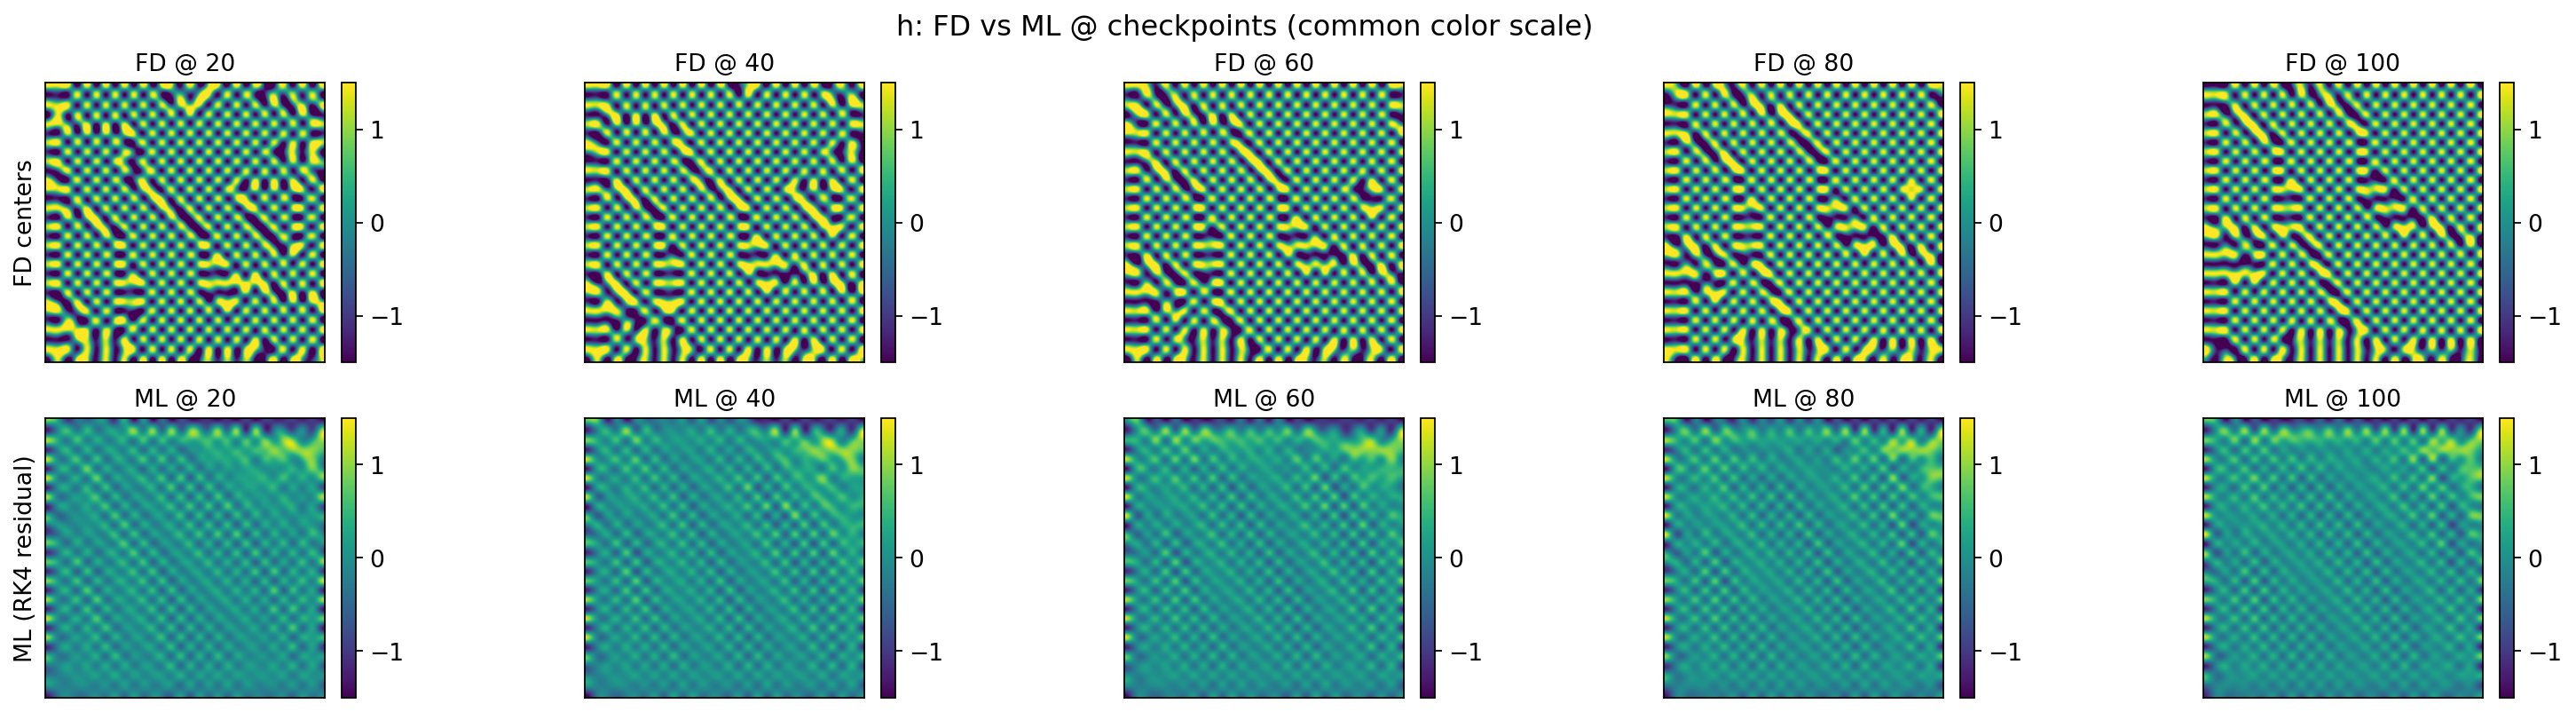

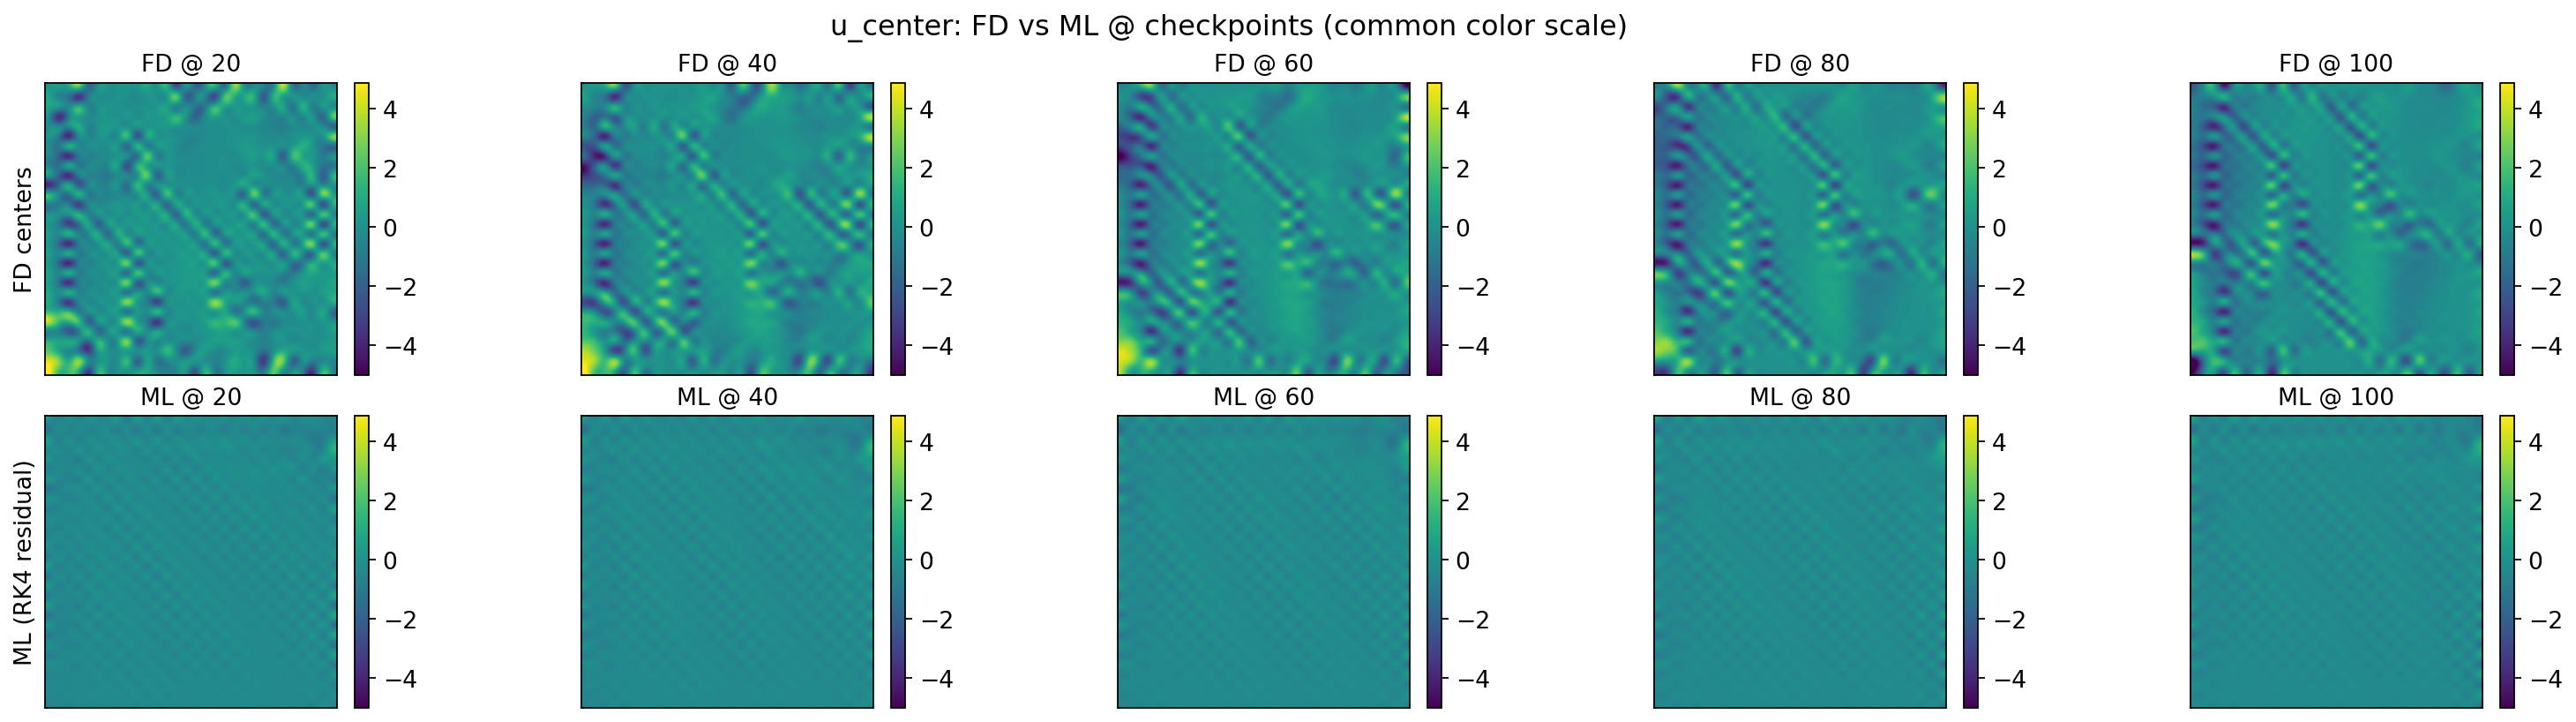

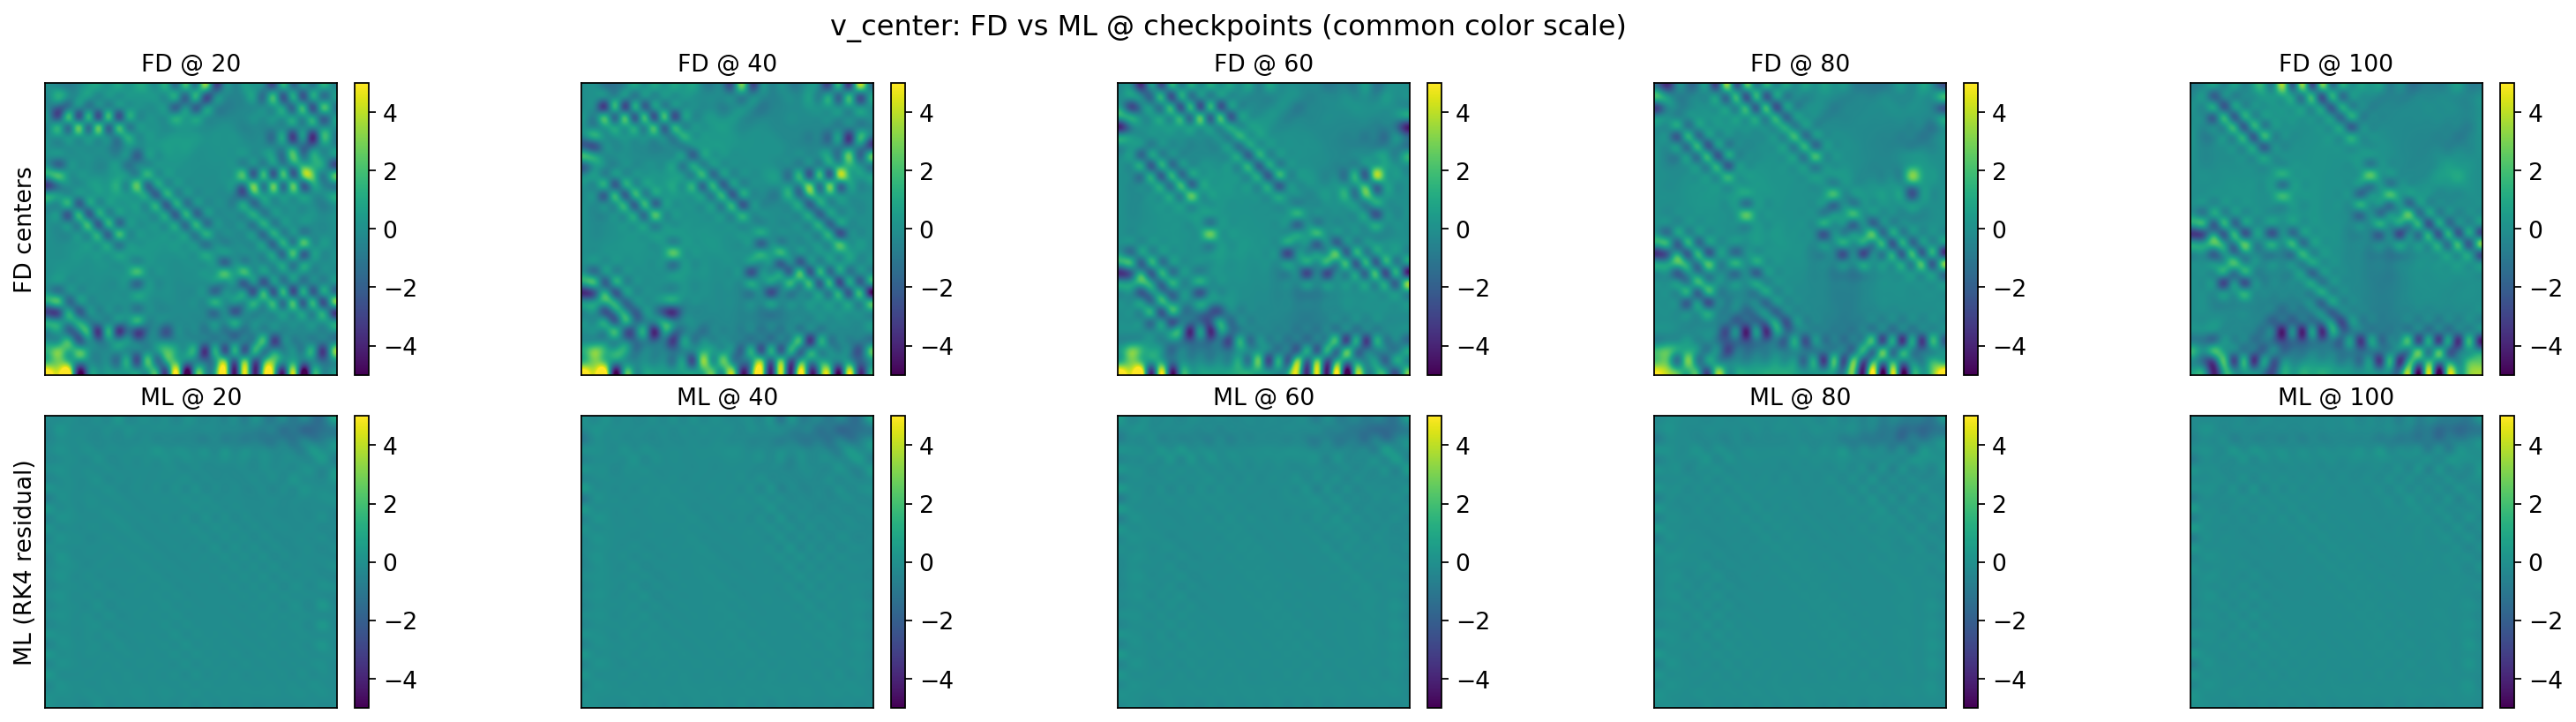

In [ ]:
# cnn_cgrid_residual_with_data_tendency_physics.py
# CNN emulator on C-grid FD truth (RK4). Physics constraint uses *data-derived* tendencies.
# Single cell, Colab-ready. No checkpoints/resume. Live prints + diagnostics + smooth plots.

import os, time, csv, math, functools
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---- flush prints immediately (see progress live) ----
print = functools.partial(print, flush=True)

# ---- nicer plots ----
plt.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 160,
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "figure.constrained_layout.use": True,
    "image.interpolation": "lanczos",  # smoother imshow globally
})

# =========================
# Config
# =========================
@dataclass
class SWConfig:
    # Grid / physics (C-grid FD)
    H: int = 30
    W: int = 30
    g: float = 9.81
    H0: float = 10.0
    dx: float = 1_000.0
    dy: float = 1_000.0
    steps: int = 300
    seed: int = 42
    cfl: float = 0.2
    substeps: int = 2
    nu: float = 1500.0

    # Training / model
    unroll_steps: int = 100
    period: int = 20
    epochs: int = 8
    channels: int = 32
    depth: int = 6
    lr: float = 1.2e-4
    grad_clip: float = 0.7

    # Physics settings
    use_cuda: bool = True
    ics: bool = True      # << set False to train without physics
    ml_substeps: int = 3
    lambda_state_main: float = 1.0
    lambda_state_thin: float = 0.2

    # Physics warm-up & scaling
    phys_warmup_epochs: int = 2
    phys_weight_max: float = 2.0
    corr_scale_start: float = 0.4
    corr_scale_end: float = 1.0
    corr_scale_ramp_epochs: int = 2

    # Clamps
    tend_clip: float = 3.0
    h_clamp: float = 1.0
    uv_clamp: float = 5.0

    # Speed: subsample training windows
    train_stride: int = 4

    # Diagnostics CSV ("" to disable)
    diag_csv: str = "diagnostics.csv"

# =========================
# Utilities
# =========================
def _ensure_dir(p): Path(p).mkdir(parents=True, exist_ok=True)

# =========================
# C-grid FD helpers (NumPy)
# =========================
def roll(a, sh, axis): return np.roll(a, shift=sh, axis=axis)
def nan_guard_np(a): return np.nan_to_num(a, nan=0.0, posinf=0.0, neginf=0.0)

def centers_to_u_faces(a):
    return 0.5*(np.concatenate([a[:, :1], a], axis=1) + np.concatenate([a, a[:, -1:]], axis=1))
def centers_to_v_faces(a):
    return 0.5*(np.concatenate([a[:1, :], a], axis=0) + np.concatenate([a, a[-1:, :]], axis=0))
def u_faces_to_centers(u_face):
    return 0.5*(u_face[:, :-1] + u_face[:, 1:])
def v_faces_to_centers(v_face):
    return 0.5*(v_face[:-1, :] + v_face[1:, :])

def ddx_u_face(f, dx):  return (roll(f, -1, 1) - roll(f, 1, 1)) / (2*dx)
def ddy_u_face(f, dy):  return (roll(f, -1, 0) - roll(f, 1, 0)) / (2*dy)
def ddx_v_face(f, dx):  return (roll(f, -1, 1) - roll(f, 1, 1)) / (2*dx)
def ddy_v_face(f, dy):  return (roll(f, -1, 0) - roll(f, 1, 0)) / (2*dy)

def lap_u_face(f, dx, dy):
    return ((roll(f,-1,1)-2*f+roll(f,1,1))/(dx*dx) +
            (roll(f,-1,0)-2*f+roll(f,1,0))/(dy*dy))
def lap_v_face(f, dx, dy):
    return ((roll(f,-1,1)-2*f+roll(f,1,1))/(dx*dx) +
            (roll(f,-1,0)-2*f+roll(f,1,0))/(dy*dy))
def lap_center(a, dx, dy):
    return ((roll(a,-1,1)-2*a+roll(a,1,1))/(dx*dx) +
            (roll(a,-1,0)-2*a+roll(a,1,0))/(dy*dy))

def divergence_flux(Hu_face, Hv_face, dx, dy):
    dFx_dx = (Hu_face[:, 1:] - Hu_face[:, :-1]) / dx
    dFy_dy = (Hv_face[1:, :] - Hv_face[:-1, :]) / dy
    return dFx_dx + dFy_dy

def v_on_u_faces(v_face):
    v_cent = 0.5*(v_face[:-1, :] + v_face[1:, :])
    return centers_to_u_faces(v_cent)
def u_on_v_faces(u_face):
    u_cent = 0.5*(u_face[:, :-1] + u_face[:, 1:])
    return centers_to_v_faces(u_cent)

def sw_rhs_cgrid_numpy(h_c, u_face, v_face, cfg: SWConfig):
    dhdx_u = (h_c - roll(h_c, 1, 1)) / cfg.dx
    dhdx_u = np.concatenate([dhdx_u[:, :1], dhdx_u], axis=1)
    dhdy_v = (h_c - roll(h_c, 1, 0)) / cfg.dy
    dhdy_v = np.concatenate([dhdy_v[:1, :], dhdy_v], axis=0)
    u_face = nan_guard_np(u_face); v_face = nan_guard_np(v_face)

    u2 = 0.5 * (u_face*u_face)
    v2 = 0.5 * (v_face*v_face)
    uv_on_u = u_face * v_on_u_faces(v_face)
    uv_on_v = v_face * u_on_v_faces(u_face)
    adv_u = ddx_u_face(u2, cfg.dx) + ddy_u_face(uv_on_u, cfg.dy)
    adv_v = ddx_v_face(uv_on_v, cfg.dx) + ddy_v_face(v2, cfg.dy)

    dudt_face = -cfg.g * dhdx_u - adv_u
    dvdt_face = -cfg.g * dhdy_v - adv_v

    if cfg.nu > 0.0:
        dudt_face = dudt_face + cfg.nu * lap_u_face(u_face, cfg.dx, cfg.dy)
        dvdt_face = dvdt_face + cfg.nu * lap_v_face(v_face, cfg.dx, cfg.dy)

    Hu = cfg.H0 * u_face
    Hv = cfg.H0 * v_face
    dhdt_center = -divergence_flux(Hu, Hv, cfg.dx, cfg.dy)
    if cfg.nu > 0.0:
        dhdt_center = dhdt_center + 0.3*cfg.nu * lap_center(h_c, cfg.dx, cfg.dy)

    return nan_guard_np(dhdt_center), nan_guard_np(dudt_face), nan_guard_np(dvdt_face)

def clamp_fd_(h, u_face, v_face):
    h = np.clip(h, -1.5, 1.5)
    u_face = np.clip(u_face, -5.0, 5.0)
    v_face = np.clip(v_face, -5.0, 5.0)
    return h, u_face, v_face

def rk4_step_cgrid_numpy(h_c, u_face, v_face, dt, cfg: SWConfig):
    k1h,k1u,k1v = sw_rhs_cgrid_numpy(h_c, u_face, v_face, cfg)
    k2h,k2u,k2v = sw_rhs_cgrid_numpy(h_c + 0.5*dt*k1h, u_face + 0.5*dt*k1u, v_face + 0.5*dt*k1v, cfg)
    k3h,k3u,k3v = sw_rhs_cgrid_numpy(h_c + 0.5*dt*k2h, u_face + 0.5*dt*k2u, v_face + 0.5*dt*k2v, cfg)
    k4h,k4u,k4v = sw_rhs_cgrid_numpy(h_c + dt*k3h,     u_face + dt*k3u,     v_face + dt*k3v,     cfg)
    h_n = h_c    + (dt/6.0)*(k1h + 2*k2h + 2*k3h + k4h)
    u_n = u_face + (dt/6.0)*(k1u + 2*k2u + 2*k3u + k4u)
    v_n = v_face + (dt/6.0)*(k1v + 2*k2v + 2*k3v + k4v)
    return clamp_fd_(nan_guard_np(h_n), nan_guard_np(u_n), nan_guard_np(v_n))

def cfl_dt_cgrid(h_c, u_face, v_face, cfg: SWConfig, cfl=None):
    if cfl is None: cfl = cfg.cfl
    c = math.sqrt(cfg.g * (cfg.H0 + float(np.max(np.abs(h_c)))))
    umax = float(np.max(np.abs(u_face))); vmax = float(np.max(np.abs(v_face)))
    speed = max(c + umax, c + vmax, 1e-6)
    return float(cfl * min(cfg.dx, cfg.dy) / speed)

def generate_sequence_cgrid(cfg: SWConfig):
    rng = np.random.default_rng(cfg.seed)
    H,W = cfg.H, cfg.W
    y,x = np.mgrid[0:H, 0:W]
    def blob(cx,cy,sx,sy,amp): return amp*np.exp(-(((x-cx)/sx)**2 + ((y-cy)/sy)**2))
    h = blob(0.25*W,0.35*H,8,10,0.08) - blob(0.70*W,0.60*H,12,8,0.06)
    u_cent = blob(0.45*W,0.30*H,12,12,0.25) - blob(0.60*W,0.70*H,10,10,0.22)
    v_cent = blob(0.60*W,0.25*H,12,12,-0.20) + blob(0.30*W,0.70*H,10,14,0.20)
    h      = h    + rng.normal(0,0.003,size=h.shape)
    u_cent = u_cent + rng.normal(0,0.003,size=u_cent.shape)
    v_cent = v_cent + rng.normal(0,0.003,size=v_cent.shape)
    u_face = centers_to_u_faces(u_cent)
    v_face = centers_to_v_faces(v_cent)
    h,u_face,v_face = clamp_fd_(nan_guard_np(h), nan_guard_np(u_face), nan_guard_np(v_face))
    dt = cfl_dt_cgrid(h, u_face, v_face, cfg, cfg.cfl)
    print(f"[FD] Generate C-grid: H={H}, W={W}, dt={dt:.6f}s, substeps={cfg.substeps}, steps={cfg.steps}, nu={cfg.nu}")
    seq_h, seq_u, seq_v = [], [], []
    for t in range(cfg.steps):
        if t % 100 == 0: print(f"  [FD] step {t}/{cfg.steps}")
        seq_h.append(h.copy()); seq_u.append(u_face.copy()); seq_v.append(v_face.copy())
        dt_sub = dt / cfg.substeps
        for _ in range(cfg.substeps):
            h, u_face, v_face = rk4_step_cgrid_numpy(h, u_face, v_face, dt_sub, cfg)
    return np.stack(seq_h,axis=0), np.stack(seq_u,axis=0), np.stack(seq_v,axis=0), dt

# =========================
# Tiny residual CNN (3×3)
# =========================
class ResBlock2D(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.bn1 = nn.GroupNorm(1, ch); self.conv1 = nn.Conv2d(ch, ch, 3, padding=1)
        self.bn2 = nn.GroupNorm(1, ch); self.conv2 = nn.Conv2d(ch, ch, 3, padding=1)
    def forward(self,x):
        h = F.gelu(self.bn1(x)); h=self.conv1(h)
        h = F.gelu(self.bn2(h)); h=self.conv2(h)
        return x+h

class TinyCNN(nn.Module):
    def __init__(self, in_ch=3, ch=32, depth=6, out_ch=3):
        super().__init__()
        self.inp=nn.Conv2d(in_ch,ch,3,padding=1)
        self.blocks=nn.ModuleList([ResBlock2D(ch) for _ in range(depth)])
        self.head=nn.Conv2d(ch,out_ch,3,padding=1)
        nn.init.zeros_(self.head.weight); nn.init.zeros_(self.head.bias)
    def forward(self,x):
        h=self.inp(x)
        for blk in self.blocks: h=blk(h)
        return self.head(h)

# =========================
# Physics RHS at centers (Torch)
# =========================
def torch_centers_to_u_faces(a): return 0.5*(torch.cat([a[...,:1],a],-1)+torch.cat([a,a[...,-1:]],-1))
def torch_centers_to_v_faces(a): return 0.5*(torch.cat([a[...,:1,:],a],-2)+torch.cat([a,a[...,-1:,:]],-2))

def physics_rhs_centers_torch(x_c, cfg: SWConfig):
    h=x_c[:,0:1]; ubar=x_c[:,1:2]; vbar=x_c[:,2:3]
    u_face=torch_centers_to_u_faces(ubar); v_face=torch_centers_to_v_faces(vbar)
    Hu=cfg.H0*u_face; Hv=cfg.H0*v_face
    dFx_dx=(Hu[...,1:]-Hu[...,:-1])/cfg.dx
    dFy_dy=(Hv[...,1:,:]-Hv[...,:-1,:])/cfg.dy
    dhdt=-(dFx_dx+dFy_dy)
    dhdx_c=(torch.roll(h,-1,-1)-torch.roll(h,1,-1))/(2*cfg.dx)
    dhdy_c=(torch.roll(h,-1,-2)-torch.roll(h,1,-2))/(2*cfg.dy)
    dudt=-cfg.g*dhdx_c; dvdt=-cfg.g*dhdy_c
    return torch.cat([dhdt,dudt,dvdt],1)

# =========================
# Main
# =========================
def main():
    cfg = SWConfig()
    # Flip this to False to run without physics
    cfg.use_physics = True

    device = torch.device('cuda' if (cfg.use_cuda and torch.cuda.is_available()) else 'cpu')
    amp_enabled = (device.type == 'cuda')
    amp_dtype = torch.bfloat16
    torch.set_default_dtype(torch.float32)
    print(f"[Main] Device={device}, PhysicsLoss={cfg.use_physics}, ML_SUBSTEPS={cfg.ml_substeps}")

    # ---- Generate FD truth
    h_seq, u_seq, v_seq, dt = generate_sequence_cgrid(cfg)
    print(f"[FD] Shapes: h{h_seq.shape}, u{u_seq.shape}, v{v_seq.shape}, dt={dt:.4f}s")

    # Face->center velocities for training/diagnostics
    uc_seq = np.stack([u_faces_to_centers(u_seq[t]) for t in range(cfg.steps)], axis=0)
    vc_seq = np.stack([v_faces_to_centers(v_seq[t]) for t in range(cfg.steps)], axis=0)

    if not np.isfinite(h_seq).all() or not np.isfinite(uc_seq).all() or not np.isfinite(vc_seq).all():
        print("[FD] non-finite values in sequence, abort."); return

    # ---- Precompute *data-derived* centered tendencies at centers (t=1..steps-2)
    # tend_data[t] ~ d/dt [h, u_cent, v_cent] at time index t
    trio_seq = np.stack([h_seq, uc_seq, vc_seq], axis=1)      # (T, 3, H, W)
    tend_data = (trio_seq[2:] - trio_seq[:-2]) / (2*dt)       # (T-2, 3, H, W), for t=1..T-2
    # store as torch on CPU, move slices to GPU when used
    tend_data_t = torch.from_numpy(tend_data).float()         # CPU tensor

    # ---- Train/val windows (subsample training)
    starts = [t for t in range(cfg.steps - 1 - cfg.unroll_steps)]
    n = len(starts)
    train_pool = starts[: int(0.8*n)]
    val_pool   = starts[int(0.8*n): int(0.9*n)]
    train_starts = train_pool[::max(1, cfg.train_stride)]
    val_starts   = val_pool
    print(f"[Data] windows total={n}, train={len(train_starts)}, val={len(val_starts)} (stride={cfg.train_stride})")

    # ---- Normalization (centers)
    Xtrain = np.stack([np.stack([h_seq[t], uc_seq[t], vc_seq[t]], axis=0)
                       for t in train_starts], axis=0)
    mean = torch.from_numpy(Xtrain.mean(axis=(0,2,3), keepdims=True)).float().to(device)
    std  = torch.from_numpy(Xtrain.std (axis=(0,2,3), keepdims=True) + 1e-6).float().to(device)

    # ---- Model / Opt / Sched
    model = TinyCNN(in_ch=3, ch=cfg.channels, depth=cfg.depth, out_ch=3).to(device)
    try:
        model = torch.compile(model)
        print("[Speed] torch.compile enabled")
    except Exception as e:
        print(f"[Speed] compile unavailable: {e}")
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=cfg.epochs)

    # ---- Schedules
    def phys_weight(epoch):
        if not cfg.use_physics: return 0.0
        return min(1.0, max(0.0, epoch / max(1, cfg.phys_warmup_epochs))) * cfg.phys_weight_max
    def corr_scale(epoch):
        a, b = cfg.corr_scale_start, cfg.corr_scale_end
        r = min(1.0, epoch / max(1, cfg.corr_scale_ramp_epochs))
        return a + (b - a) * r

    # ---- Stability clamps
    TEND_CLIP  = cfg.tend_clip
    H_CLAMP    = cfg.h_clamp
    UV_CLAMP   = cfg.uv_clamp
    def clamp_state_(x):
        x[:,0].clamp_(-H_CLAMP, H_CLAMP)
        x[:,1].clamp_(-UV_CLAMP, UV_CLAMP)
        x[:,2].clamp_(-UV_CLAMP, UV_CLAMP)
        return x

    # ---- Model correction & RHS
    def model_correction(x, epoch):
        with torch.amp.autocast(device_type="cuda", enabled=amp_enabled, dtype=amp_dtype):
            xn = (x - mean) / std
            delta = model(xn)  # (1,3,H,W)
        cscale = corr_scale(epoch)
        corr = cscale * torch.tanh(delta)
        # monitor magnitude occasionally
        # print(f"      [corr] |delta|={delta.abs().mean().item():.3e}, |corr|={corr.abs().mean().item():.3e}, cscale={cscale:.2f}")
        return corr

    def rhs_total(x, epoch):
        base = physics_rhs_centers_torch(x, cfg)
        corr = model_correction(x, epoch)
        t = base + corr
        return torch.clamp(torch.nan_to_num(t), -TEND_CLIP, TEND_CLIP)

    def rk4_model_step(x, epoch):
        sub_dt = dt / max(1, int(cfg.ml_substeps))
        for _ in range(max(1, int(cfg.ml_substeps))):
            x = clamp_state_(torch.nan_to_num(x))
            k1 = rhs_total(x, epoch)
            x2 = clamp_state_(torch.nan_to_num(x + 0.5*sub_dt*k1))
            k2 = rhs_total(x2, epoch)
            x3 = clamp_state_(torch.nan_to_num(x + 0.5*sub_dt*k2))
            k3 = rhs_total(x3, epoch)
            x4 = clamp_state_(torch.nan_to_num(x + sub_dt*k3))
            k4 = rhs_total(x4, epoch)
            x = x + (sub_dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
            x = clamp_state_(torch.nan_to_num(x))
        return x

    def fetch_center_state(t):
        x = np.stack([h_seq[t], uc_seq[t], vc_seq[t]], axis=0)
        return torch.from_numpy(x).unsqueeze(0).float().to(device)

    # ---- Training epoch (uses data-derived tendency at checkpoints)
    L_MAIN = cfg.lambda_state_main
    L_THIN = cfg.lambda_state_thin

    def run_epoch(starts_list, train=True, current_epoch=1):
        model.train() if train else model.eval()
        total = 0.0
        nwin = len(starts_list)

        for idx in range(nwin):
            t0 = starts_list[idx]
            if (idx % 40) == 0:
                print(f"  [{'Train' if train else ' Val '}] window {idx+1}/{nwin} t0={t0} ep={current_epoch}")

            xk = fetch_center_state(t0)
            loss = torch.zeros([], device=device)

            for k in range(1, cfg.unroll_steps+1):
                xk = rk4_model_step(xk, current_epoch)
                if not torch.isfinite(xk).all():
                    xk = clamp_state_(torch.nan_to_num(xk))

                tref = t0 + k
                if k % 10 == 0 or k % cfg.period == 0:
                    x_ref = fetch_center_state(tref)
                    w = (L_MAIN if (k % cfg.period == 0) else L_THIN)
                    ls = F.mse_loss(xk, x_ref)    # state alignment
                    loss_term = w * ls

                    if (k % cfg.period == 0):
                        pw = phys_weight(current_epoch)
                        # Physics constraint with *data* tendency: need tref-1 and tref+1
                        if cfg.use_physics and pw > 0 and (1 <= tref < (cfg.steps-1)):
                            tend_ref = tend_data_t[tref-1:tref, ...].to(device)  # shape (1,3,H,W)
                            tend_ml  = rhs_total(xk, current_epoch).detach()      # model total tendency at current x
                            lp = F.mse_loss(tend_ml, tend_ref)
                            loss_term = loss_term + pw * lp
                            print(f"    [k={k:3d}] L_state={ls.item():.3e}, L_phys={lp.item():.3e}, pw={pw:.2f}")
                        else:
                            print(f"    [k={k:3d}] L_state={ls.item():.3e}")

                    loss = loss + loss_term

            if not torch.isfinite(loss):
                print("  [warn] non-finite loss; skip optimizer step")
            elif train:
                opt.zero_grad(set_to_none=True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
                opt.step()

            total += float(loss.detach().cpu())

        if train: sched.step()
        return total / max(1, nwin)

    # ---- Train
    print("[Train] Starting ...")
    best = float('inf')
    for ep in range(1, cfg.epochs+1):
        tr = run_epoch(train_starts, True,  current_epoch=ep)
        va = run_epoch(val_starts,   False, current_epoch=ep)
        best = min(best, va)
        print(f"[Epoch {ep}] train={tr:.6f} | val={va:.6f} | best={best:.6f}")

        # Quick RMSE @ checkpoints
        CHECKS = [20,40,60,80,100]
        t0_eval = 50
        with torch.no_grad():
            x0 = fetch_center_state(t0_eval)
            xk = x0.clone()
            rmses = []
            for s in range(cfg.unroll_steps):
                xk = rk4_model_step(xk, ep)
                if (s+1) in CHECKS:
                    x_ref = fetch_center_state(t0_eval + (s+1))
                    diff = (xk - x_ref)
                    rmse = torch.sqrt((diff**2).mean(dim=(-2,-1))).cpu().numpy()
                    rmses.append(((s+1), rmse))
        if rmses:
            def _fmt_rmse(r):
                r = np.array(r).reshape(-1)[:3]
                h,u,v = float(r[0]), float(r[1]), float(r[2])
                return f"h={h:.3e}, u={u:.3e}, v={v:.3e}"
            msg = " | ".join([f"{t}: {_fmt_rmse(r)}" for t, r in rmses])
            print(f"[Epoch {ep}] RMSE@20/40/60/80/100 -> {msg}")

    print("\n[Train] Done.")

    # ---- Final evaluation + diagnostics over 100 steps
    CHECKS = [20,40,60,80,100]
    t0_eval = 50
    print(f"\n[Eval] Rolling out from t0={t0_eval} ...")
    x0 = fetch_center_state(t0_eval)

    # Truth at centers
    truth_states = [fetch_center_state(t0_eval+s)[0] for s in range(cfg.unroll_steps+1)]
    truth_states = torch.stack(truth_states, dim=0)  # (T+1,3,H,W)

    # ML rollout (final epoch scales)
    model.eval()
    with torch.no_grad():
        xk = x0.clone()
        ml_states = [xk[0].clone()]
        for _ in range(cfg.unroll_steps):
            xk = rk4_model_step(xk, cfg.epochs)
            ml_states.append(xk[0].clone())
        ml_states = torch.stack(ml_states, dim=0)

    # ---------- Diagnostics ----------
    area = cfg.dx * cfg.dy

    def rmse_all(ml, tr):
        diff = ml - tr
        return torch.sqrt((diff**2).mean(dim=(-2,-1))).cpu().numpy()  # (T+1,3)

    def total_mass(x):  # ∑ h * dx * dy  (mass anomaly)
        # accepts (T+1,3,H,W) or (T+1,H,W)
        if isinstance(x, torch.Tensor):
            if x.dim()==4 and x.shape[1]==3: h = x[:,0]
            else: h = x
            return (h.sum(dim=(-2,-1)) * area).detach().cpu().numpy()
        arr = np.asarray(x)
        if arr.ndim==4 and arr.shape[1]==3: h = arr[:,0]
        else: h = arr
        return (h.sum(axis=(-2,-1)) * area)

    def total_energy(x):  # ∑ [ 0.5*H0*(u^2+v^2) + 0.5*g*h^2 ] * dx * dy
        h = x[:,0]; u = x[:,1]; v = x[:,2]
        ke = 0.5*cfg.H0*(u*u + v*v) * area
        pe = 0.5*cfg.g*(h*h)       * area
        return (ke + pe).sum(dim=(-2,-1)).cpu().numpy()

    rmse_ts = rmse_all(ml_states, truth_states)
    mass_fd = total_mass(truth_states)
    mass_ml = total_mass(ml_states)
    ener_fd = total_energy(truth_states)
    ener_ml = total_energy(ml_states)

    if cfg.diag_csv:
        print(f"[Diag] Writing CSV: {cfg.diag_csv}")
        _ensure_dir(os.path.dirname(cfg.diag_csv) or ".")
        with open(cfg.diag_csv, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["step","time_s","rmse_h","rmse_u","rmse_v","mass_fd","mass_ml","mass_diff","energy_fd","energy_ml","energy_diff"])
            for s in range(rmse_ts.shape[0]):
                tsec = s*dt
                w.writerow([
                    s, f"{tsec:.6f}",
                    float(rmse_ts[s,0]), float(rmse_ts[s,1]), float(rmse_ts[s,2]),
                    float(mass_fd[s]), float(mass_ml[s]), float(mass_ml[s]-mass_fd[s]),
                    float(ener_fd[s]), float(ener_ml[s]), float(ener_ml[s]-ener_fd[s]),
                ])

    # ---------- Plots: time series ----------
    T = rmse_ts.shape[0]-1
    times = np.arange(T+1)*dt

    fig, axes = plt.subplots(3, 1, figsize=(9, 9))
    axes[0].plot(times, rmse_ts[:,0], label="RMSE(h)")
    axes[0].plot(times, rmse_ts[:,1], label="RMSE(u)")
    axes[0].plot(times, rmse_ts[:,2], label="RMSE(v)")
    axes[0].set_title("RMSE over rollout"); axes[0].set_xlabel("Time [s]"); axes[0].set_ylabel("RMSE")
    axes[0].grid(True, alpha=0.3); axes[0].legend()

    axes[1].plot(times, mass_fd, label="Mass FD")
    axes[1].plot(times, mass_ml, label="Mass ML", linestyle="--")
    axes[1].plot(times, mass_ml - mass_fd, label="ΔMass (ML - FD)", linestyle=":")
    axes[1].set_title("Total mass anomaly"); axes[1].set_xlabel("Time [s]"); axes[1].set_ylabel("∑h·dx·dy")
    axes[1].grid(True, alpha=0.3); axes[1].legend()

    axes[2].plot(times, ener_fd, label="Energy FD")
    axes[2].plot(times, ener_ml, label="Energy ML", linestyle="--")
    axes[2].plot(times, ener_ml - ener_fd, label="ΔEnergy (ML - FD)", linestyle=":")
    axes[2].set_title("Total energy"); axes[2].set_xlabel("Time [s]"); axes[2].set_ylabel("J (rel.)")
    axes[2].grid(True, alpha=0.3); axes[2].legend()
    plt.suptitle("Diagnostics over rollout")
    plt.show()

    # ---------- Plots: FD vs ML fields at checkpoints ----------
    def show_field_grid(fid, name):
        CHECKS = [20,40,60,80,100]
        vmins, vmaxs = [], []
        for s in CHECKS:
            vmins += [float(torch.min(truth_states[s,fid]).cpu()), float(torch.min(ml_states[s,fid]).cpu())]
            vmaxs += [float(torch.max(truth_states[s,fid]).cpu()), float(torch.max(ml_states[s,fid]).cpu())]
        vmin = min(vmins); vmax = max(vmaxs)

        fig, axes = plt.subplots(2, len(CHECKS), figsize=(3.8*len(CHECKS), 5))
        for j,s in enumerate(CHECKS):
            im0 = axes[0,j].imshow(truth_states[s,fid].cpu(), origin='lower', vmin=vmin, vmax=vmax)
            axes[0,j].set_title(f"FD @ {s}")
            im1 = axes[1,j].imshow(ml_states[s,fid].cpu(),    origin='lower', vmin=vmin, vmax=vmax)
            axes[1,j].set_title(f"ML @ {s}")
            fig.colorbar(im0, ax=axes[0,j], fraction=0.046, pad=0.04)
            fig.colorbar(im1, ax=axes[1,j], fraction=0.046, pad=0.04)
            for ax in (axes[0,j], axes[1,j]): ax.set_xticks([]); ax.set_yticks([])
        axes[0,0].set_ylabel("FD centers"); axes[1,0].set_ylabel("ML (RK4 residual)")
        plt.suptitle(f"{name}: FD vs ML @ checkpoints (common color scale)")
        plt.show()

    show_field_grid(0, "h")
    show_field_grid(1, "u_center")
    show_field_grid(2, "v_center")

if __name__ == "__main__":
    main()
